# Sentiment Analysis of Financial News

The data source is available at [Kaggle](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news?resource=download). 

**Context**: This dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.

In [39]:
import time
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize

import transformers # transformers library by Hugging Face

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# from torchtext.vocab import GloVe
# from torchtext.data.utils import get_tokenizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay,  precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

import pickle
import joblib 

We first do a GPU check.

In [2]:
print(torch.version.cuda)
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

12.4
True
1
0
NVIDIA GeForce GTX 960M


In [3]:
os.getcwd()

'D:\\Data\\PyCharmProjects\\MAS-sentiment-analysis\\sent_analysis'

In [4]:
data = pd.read_csv("D:\Data\PyCharmProjects\MAS-sentiment-analysis\data/financial_news.csv", 
                   names=['sentiment', 'news'])
data.sample(10)

,sentiment,news
2614,neutral,The contract covers turnkey deliveries to all ...
2379,neutral,"The largest construction company in Finland , ..."
3084,neutral,Pohjola will act as the manager of the issue a...
4668,negative,Diluted earnings per share ( EPS ) declined to...
722,positive,"Operating profit totalled EUR 5.8 mn , up from..."
4448,negative,Return on capital employed ROCE was a negative...
2795,neutral,"Also in Latvia , we act as a partner for baker..."
1713,negative,Sales of mid-strength beer decreased by 40 % .
804,positive,Finnish construction group YIT has been awarde...
1546,positive,It also has strong assets in electronic media ...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   news       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


Our dataframe consists of 4,846 rows with just two columns i.e sentiment and news.

## Data Analysis

In [ ]:
value_counts = data['sentiment'].value_counts(normalize=True) * 100  # Get percentages
count_with_percentages = data['sentiment'].value_counts().to_frame('counts')  # Get counts
count_with_percentages['percentage'] = round(value_counts, 2)  # Add percentages to the DataFrame

print(count_with_percentages)

In [ ]:
def pie_plot():
    # Calculate counts and percentages
    value_counts = data['sentiment'].value_counts()
    percentages = value_counts / value_counts.sum() * 100
    
    # Create labels with both values and percentages
    labels = [f'{label}: {count}' for label, count in zip(value_counts.index, value_counts)]
    
    # Define the explode parameter to separate the "negative" slice
    explode = [0.05 if label == 'negative' else 0 for label in value_counts.index]
    
    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(value_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, explode=explode)
    plt.title('Sentiment Distribution on Financial Dataset')
    plt.show()

In [ ]:
pie_plot()

## Data Preprocessing

In [6]:
# Encode the sentiment labels to integers
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['sentiment'])

With the encoder, we have 
- negative = 0, 
- neutral = 1, 
- positive = 2.

In [27]:
data.sample(50)

,sentiment,news,sentiment_encoded
2089,neutral,Cymed 's net sales are expected to amount to E...,1
3646,neutral,It comes complete with an LCD touch screen sys...,1
2929,neutral,He is a Chartered Accountant in British Columb...,1
1538,neutral,"In Finland , the corresponding service is Alma...",1
1314,neutral,Poyry Energy GmbH is Austria 's leading engine...,1
949,positive,fi is developing cooperation in keyword advert...,2
611,positive,"In addition , Cramo and Peab have signed exclu...",2
3370,neutral,The Swedish player became majority owner of UC...,1
2160,neutral,Net sales in 2006 totaled EUR 302 million and ...,1
3309,neutral,"The orders consist in total of over 1,600 pane...",1


In [7]:
# Split the data into features (X) and target (y)
X = data['news'].values
y = data['sentiment_encoded'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models

## 1. LSTM Model

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, max_len=100):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.unk_idx = self.vocab.stoi.get('<unk>', len(self.vocab.stoi))
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokenized = [self.vocab.stoi.get(token, self.unk_idx) for token in self.tokenizer(text)]
        tokenized = [idx if idx < len(self.vocab.stoi) else 0 for idx in tokenized] 

        # # Debugging: Check if any index is out of range
        # if torch.any(tokenized_tensor >= len(self.vocab.stoi)):
        #     print(f"Out-of-range index in text at index {idx}: {text}")
        #     print(f"Tokenized indices: {tokenized_tensor}")
        #     print(f"Vocabulary size: {len(self.vocab.stoi)}")

        return torch.tensor(tokenized, dtype=torch.long), label

In [ ]:
# Initialize the GloVe vocabulary and tokenizer
glove = GloVe(name='6B', dim=100)  # 100-dimensional GloVe vectors
tokenizer = get_tokenizer("basic_english")

# Create datasets
train_dataset = SentimentDataset(X_train, y_train, glove, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, glove, tokenizer)

# Define a collate function to pad sequences
def collate_batch(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return texts_padded, torch.tensor(labels, dtype=torch.long)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Use the last hidden state
        out = self.fc(lstm_out)
        return out

In [ ]:
vocab_size = len(glove.stoi)
embedding_dim = 100
hidden_dim = 128
output_dim = 3  # Three sentiment classes

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)

# Initialize the embeddings with GloVe vectors
model.embedding.weight.data.copy_(glove.vectors)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
%%time

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for texts, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')


In [ ]:
# Assuming you have a test DataLoader named `test_loader`

# 1. Set the model to evaluation mode
model.eval()

# 2. Disable gradient computation as we are not training
with torch.no_grad():
    all_predictions = []
    all_labels = []

    # 3. Iterate over the test data
    for texts, labels in test_loader:
        # Forward pass to get predictions
        outputs = model(texts)
        
        # Get the predicted class by finding the index with the max value
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and labels for metric computation
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

In [ ]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Assuming you have a test DataLoader named `test_loader`
# and the model is already trained and loaded.

# 1. Set the model to evaluation mode
model.eval()

# 2. Disable gradient computation
all_predictions = []
all_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        # Forward pass
        outputs = model(texts)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions and true labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 4. Display the confusion matrix using matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for LSTM Model")
plt.show()

In [ ]:
# Assuming `model` is your trained model
torch.save(model.state_dict(), './models/lstm/lstm_model.pth')

## 2. DistilBERT & Logistic Regression

The DistilBERT processes the input sentence and passes on the relevant information to the Logistic Regression Model for sentiment classification. It is BERT lite. 

In [8]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [9]:
# tokenize all the reviews in column 0 of the dataframe "df"
tokenized = data['news'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
def visualized_sentence_embedding(df: pd.DataFrame, tokenized: pd.Series) -> pd.DataFrame:
    """
    Function to see tokens and embeddings of the first review in df.
    """
    tokens = data.iloc[0,1].split(" ")
    tokens.insert(0, "CLS")
    tokens.append("SEP")
    assert len(tokens) == len(tokenized[0])
    token_embeddings = list(zip(tokens, tokenized[0]))
    df_token_embeddings = pd.DataFrame(token_embeddings, columns=["Tokens", "Embeddings"])
    return df_token_embeddings

In [ ]:
df_token_embeddings = visualized_sentence_embedding(data, tokenized)
df_token_embeddings.head(500)

We pad to ensure that each sentence in the news column all have the same number of tokens.

In [10]:
max_len = 0
max_len = max([len(i) for i in tokenized.values if len(i) > max_len])
padded_token_embeddings = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print(max_len)
print(padded_token_embeddings.shape)

150
(4846, 150)


We create a separate variable called attention_mask. This variable indicates which tokens should be attended to by the model and which tokens should be ignored (masked) during processing. By setting the attention mask to 1 for the real tokens and 0 for the padding tokens, we can tell BERT to ignore the padding when processing the input. This helps to improve the accuracy of the model's predictions.

In [11]:
attention_mask = np.where(padded_token_embeddings != 0, 1, 0)
assert attention_mask.shape == padded_token_embeddings.shape
print(attention_mask.shape)

(4846, 150)


Model inputs

In [12]:
# move model and data to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.cuda.empty_cache()

model.to(device)  # Move the model to the GPU

cuda


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [13]:
batch_size = 8  # Adjust this to a smaller number that fits your GPU memory

input_ids = torch.tensor(padded_token_embeddings)
attention_mask = torch.tensor(attention_mask)

# Assuming you have your input_ids and attention_mask tensors
input_ids_batches = torch.split(input_ids, batch_size)
attention_mask_batches = torch.split(attention_mask, batch_size)

In [14]:
last_hidden_states = []
start = time.time()

with torch.no_grad():
    for input_ids_batch, attention_mask_batch in zip(input_ids_batches, attention_mask_batches):
        outputs = model(input_ids_batch.to(device), attention_mask=attention_mask_batch.to(device))
        last_hidden_states.append(outputs[0].cpu())  # Move outputs to CPU to free GPU memory

end = time.time()
print(round((end - start)/60, 2), 'minutes') # time in seconds
last_hidden_states = torch.cat(last_hidden_states, dim=0)

2.14 minutes


In [15]:
last_hidden_states.shape

torch.Size([4846, 150, 768])

In [16]:
last_hidden_states[:,0,:].numpy()

array([[-0.05965231, -0.04427946,  0.09823396, ..., -0.25419524,
         0.42846027,  0.14189394],
       [ 0.02817502, -0.03843351,  0.03074709, ..., -0.289469  ,
         0.3876088 ,  0.33288273],
       [-0.15720439, -0.06547945, -0.16386609, ...,  0.0989271 ,
         0.32232112,  0.4168479 ],
       ...,
       [-0.19326162, -0.20322211,  0.08441579, ..., -0.13185118,
         0.4103331 ,  0.07789858],
       [-0.10675114, -0.05250451,  0.23204601, ..., -0.10682876,
         0.61342484, -0.00559367],
       [-0.12045252, -0.23077698,  0.39699987, ..., -0.37821466,
         0.36618307,  0.19214092]], dtype=float32)

In [17]:
if not os.path.exists("./models/DB_n_LR/"): # check if directory exists, else, create it!!!
    os.mkdir("./models/DB_n_LR/")
# save trained DistilBERT model
torch.save(model.state_dict(), './models/DB_n_LR/DB.pth')

In [ ]:
# input_ids = torch.tensor(padded_token_embeddings)
# attention_mask = torch.tensor(attention_mask)
# 
# # moving data to GPU
# input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

In [ ]:
# start = time.time()
# 
# # !set CUDA_LAUNCH_BLOCKING=1
# 
# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)
# 
# end = time.time()
# print(end - start) # time in seconds

In [18]:
# extracting features and labels
features = last_hidden_states[:,0,:].numpy()
print(features.shape)

(4846, 768)


In [19]:
labels = data['sentiment_encoded']
assert len(features) == len(labels)

In [20]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

## Logistic Regression

In [50]:
lr_clf = LogisticRegression(C=5, max_iter=1000) # baseline LR model
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=5, max_iter=1000)

In [51]:
# see how our trained LR model performs on the test set
lr_clf.score(test_features, test_labels)

0.7804123711340206

### Hyperparameter tuning of the LR model.

In [52]:
lr = LogisticRegression(random_state=42)

params_lr = {
    'penalty': ['l1','l2', 'elasticnet'],
    'l1_ratio' : np.arange(0., 1.0, 0.1),
    'solver' : ['saga'],
    'tol': [0.1, 0.01, 0.001, 0.0001, 0.00001],
    'C' : [1, 5, 10, 100],
}

# Instantiate the grid search model
grid_search_lr = GridSearchCV(estimator=lr,
                           param_grid=params_lr,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [53]:
%%time
grid_search_lr.fit(train_features, train_labels)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


C:\Users\oluse\anaconda3\envs\udacitydlnndg\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1000 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
275 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\oluse\anaconda3\envs\udacitydlnndg\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\oluse\anaconda3\envs\udacitydlnndg\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\oluse\anaconda3\envs\udacitydlnndg\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    va

CPU times: total: 47.8 s
Wall time: 1h 35min 21s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['saga'],
                         'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05]},
             scoring='accuracy', verbose=1)

In [54]:
grid_search_lr.best_score_, grid_search_lr.best_estimator_

(0.773997672098437,
 LogisticRegression(C=1, l1_ratio=0.7000000000000001, penalty='elasticnet',
                    random_state=42, solver='saga', tol=0.01))

In [23]:
lr_best = LogisticRegression(C=1, l1_ratio=0.7, penalty='elasticnet',
                    random_state=42, solver='saga', tol=0.01)

In [28]:
%%time

start = time.time()

lr_best.fit(train_features, train_labels)

# see how our trained LR model performs on the test set
print('Best LR model accuracy:', lr_best.score(test_features, test_labels))

end = time.time()
print(round((end - start)/60, 2), 'minutes') # time in minutes
print(round((end - start)/1, 2), 'seconds') # time in minutes

Best LR model accuracy: 0.790721649484536
0.2 minutes
11.74 seconds
CPU times: total: 10.9 s
Wall time: 11.7 s


## LR evaluation

In [36]:
# Predict on the test set
y_pred = lr_best.predict(test_features)
# train_features, test_features, train_labels, test_labels 

# Evaluate the model
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average='weighted')
recall = recall_score(test_labels, y_pred, average='weighted')
f1 = f1_score(test_labels, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred))

Accuracy: 0.7907
Precision: 0.7855
Recall: 0.7907
F1 Score: 0.7849

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.61      0.66       110
           1       0.82      0.91      0.86       571
           2       0.74      0.63      0.68       289

    accuracy                           0.79       970
   macro avg       0.76      0.72      0.73       970
weighted avg       0.79      0.79      0.78       970



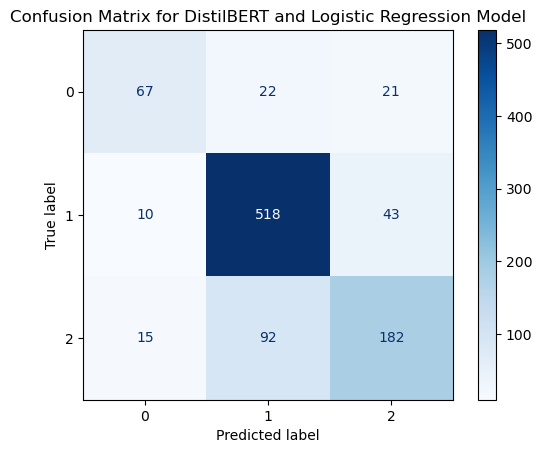

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lr_best.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for DistilBERT and Logistic Regression Model')
plt.show()

saving the model 

In [41]:
# Save the model
with open('./models/DB_n_LR/logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(lr_best, file)

In [42]:
joblib.dump(lr_best, './models/DB_n_LR/logistic_regression_model.joblib')

['./models/DB_n_LR/logistic_regression_model.joblib']

To load the model:

In [ ]:
# with pickle
with open('./models/DB_n_LR/logistic_regression_model.pkl', 'rb') as file:
    lr_model = pickle.load(file)

In [ ]:
# Load the model with joblib
lr_model = joblib.load('logistic_regression_model.joblib')

# Pretrained Transformer